In [1]:
import keras
import os 
import glob
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

width = 128
height = 128

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWar

In [2]:
# Ścieżka katalogu, do którego rozpakowano oryginalny zbiór danych.
dataset_dir = 'dataset'

# umieszczenie wszystkich danych do tablic x_data i y_data
x_data = []
y_data = []

for i in range(0, 6): # Loop over the six top-level folders
  for j in os.listdir(dataset_dir + '/0' + str(i) + '/'):
    if not j.startswith('.'): # Again avoid hidden folders
        path = dataset_dir + '/0' + str(i) + '/' + j
        x_data.append(path)
        y_data.append('0' + str(i))
  
  
# podziel dane na 3 zbiory  
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

In [3]:
# Ścieżka katalogu, w którym będą znajdować się podzielone zbiory: treningowy, walidacyjny i testowy
base_dir = 'splitted'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

    # Katalogi podzbiorów (zbioru treningowego, walidacyjnego i testowego).
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
    validation_dir = os.path.join(base_dir, 'validation')
    os.mkdir(validation_dir)
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [6]:
print(x_train[0])
print(y_train[0])

dataset/00/892.jpg
00


In [7]:
# tworzy foldery etykiet train
for i in range(len(y_train)):
  path = os.path.join(train_dir, y_train[i])
  if os.path.isdir(path) == False:
    os.mkdir(path)
    
# tworzy foldery etykiet validation
for i in range(len(y_validate)):
  path = os.path.join(validation_dir, y_validate[i])
  if os.path.isdir(path) == False:
    os.mkdir(path)

In [8]:
# Przerzucenie obrazkow traningowych do nowego katalogu
for i in range(len(x_train)):
  path = x_train[i]
  fileName = path[x_train[i].rfind('/')+1:]
  dst = os.path.join(train_dir, y_train[i], fileName)
  shutil.copyfile(x_train[i], dst)
  
# Przerzucenie obrazkow validacyjnych do nowego katalogu
for i in range(len(x_validate)):
  path = x_validate[i]
  fileName = path[x_validate[i].rfind('/')+1:]
  dst = os.path.join(validation_dir, y_validate[i], fileName)
  shutil.copyfile(x_validate[i], dst)

In [9]:
# Model sieci
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

# Podsumowanie
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)     

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
        # Katalog docelowy.
        train_dir,
        # Zmienia rozdzielczość wszystkich obrazów na 128x128.
        target_size=(height, width),
        color_mode='grayscale',
        batch_size=20,
        # Używamy funkcji binary_crossentropy w charakterze funkcji straty, a więc potrzebujemy binarnych etykiet.
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        color_mode='grayscale',
        batch_size=20,
        class_mode='categorical')

Found 4800 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [12]:
for data_batch, labels_batch in train_generator:
    print('kształt danych wsadowych:', data_batch.shape)
    print('kształt etykiet danych wsadowych:', labels_batch.shape)
    break

kształt danych wsadowych: (20, 128, 128, 1)
kształt etykiet danych wsadowych: (20, 6)


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)


Epoch 1/30
100/100 [==============================] - 37s 375ms/step - loss: 0.2308 - accuracy: 0.9265 - val_loss: 4.4736e-05 - val_accuracy: 1.0000
Epoch 2/30
100/100 [==============================] - 37s 368ms/step - loss: 0.0194 - accuracy: 0.9960 - val_loss: 2.9638e-04 - val_accuracy: 0.9940
Epoch 3/30
100/100 [==============================] - 37s 371ms/step - loss: 0.0189 - accuracy: 0.9970 - val_loss: 2.3305e-06 - val_accuracy: 1.0000
Epoch 4/30
100/100 [==============================] - 37s 370ms/step - loss: 7.4600e-05 - accuracy: 1.0000 - val_loss: 2.1458e-07 - val_accuracy: 1.0000
Epoch 5/30
100/100 [==============================] - 37s 374ms/step - loss: 0.0071 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 0.9970
Epoch 6/30
100/100 [==============================] - 37s 371ms/step - loss: 0.0539 - accuracy: 0.9970 - val_loss: 1.9670e-07 - val_accuracy: 1.0000
Epoch 7/30
100/100 [==============================] - 37s 375ms/step - loss: 2.7142e-06 - accuracy: 1

In [14]:
# Zapisanie modelu
model.save('hand_gesture_recognition.h5')

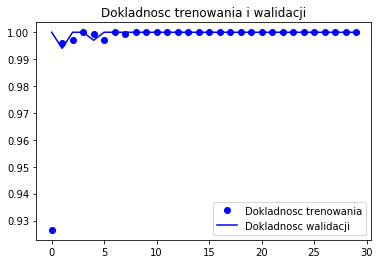

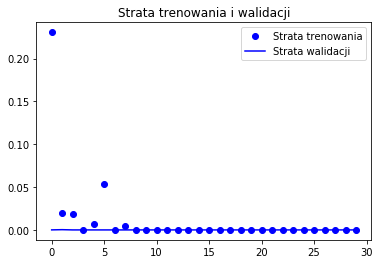

In [19]:
# Wykres strat i dokładności pracy modelu podczas przetwarzania danych treningowych i walidacyjnych
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

In [20]:
# tworzy foldery etykiet test
for i in range(len(y_test)):
  path = os.path.join(test_dir, y_test[i])
  if os.path.isdir(path) == False:
    os.mkdir(path)

In [21]:
# Przerzucenie obrazkow testowych do nowego katalogu
for i in range(len(x_test)):
  path = x_test[i]
  fileName = path[x_test[i].rfind('/')+1:]
  dst = os.path.join(test_dir, y_test[i], fileName)
  shutil.copyfile(x_test[i], dst)

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        color_mode='grayscale',
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('dokładnosc podczas testowania:', test_acc)

Found 600 images belonging to 6 classes.
dokładnosc podczas testowania: 1.0


In [42]:
img_path = '30.jpg'

In [43]:
from keras.preprocessing import image
img = image.load_img(img_path, color_mode='grayscale', target_size=(128, 128))

In [44]:
img_tensor = image.img_to_array(img)

In [45]:
import numpy as np
img_tensor = np.expand_dims(img_tensor, axis=0)

In [46]:
img_tensor /= 255.

In [47]:
print(img_tensor.shape)

(1, 128, 128, 1)


In [48]:
result = model.predict(img_tensor)

In [49]:
prediction = {'00': result[0][0], 
                  '01': result[0][1], 
                  '02': result[0][2],
                  '03': result[0][3],
                  '04': result[0][4],
                  '05': result[0][5]}

In [50]:
import operator
prediction = sorted(prediction.items(), key=operator.itemgetter(1), reverse=True)

In [51]:
print('Result: ' + prediction[0][0])

Result: 04
